In [148]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

#os.chdir("../../..")

In [149]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# additional parameters
import yfinance as yf
import pandas_ta as ta


# Prepare Dataset

In [150]:
# load stock data
# maybe replace with api-call
df = pd.read_csv("AMD.csv")

df.rename(columns={"Date": "date"}, inplace=True)
df["date"] = pd.to_datetime(df["date"])

df['static'] = 2 # static for defining the group
df.static = df.static.astype(str)

df['time_idx'] = df.index

df["month"] = df.date.dt.month.astype(str).astype("category")  # categories have to be strings
df["day"] = df.date.dt.day.astype(str).astype("category")

# Own Custom Strategy
CustomStrategy = ta.Strategy(
    name="Momo and Volatility",
    description="SMA 50,200, BBANDS, RSI, MACD and Volume SMA 20",
    ta=[
        {"kind": "sma", "length": 50},
        {"kind": "sma", "length": 200},
        {"kind": "bbands", "length": 20},
        {"kind": "rsi"},
        {"kind": "macd", "fast": 8, "slow": 21},
        {"kind": "sma", "close": "volume", "length": 20, "prefix": "VOLUME"},
    ]
)
df.ta.strategy(CustomStrategy)

# drop nan rows -> come from indicator length
df.dropna(inplace=True)

# High and Low are not needed
df.drop(columns=['High', 'Low'], inplace=True)

In [151]:
'''
# load sentiment dataset
sent = pd.read_json("NEWS_SENTIMENT/data/EODHD_SENTIMENT_AMD_2018-2023.json")

sent.date = pd.to_datetime(sent.date)
sent.drop(columns=['count'], inplace=True)

sent.rename(columns={"normalized": "norm_sentiment"}, inplace=True)
'''

'\n# load sentiment dataset\nsent = pd.read_json("NEWS_SENTIMENT/data/EODHD_SENTIMENT_AMD_2018-2023.json")\n\nsent.date = pd.to_datetime(sent.date)\nsent.drop(columns=[\'count\'], inplace=True)\n\nsent.rename(columns={"normalized": "norm_sentiment"}, inplace=True)\n'

In [152]:
'''
# merge sentiment and stock data
data = pd.merge(df, sent, how='left', on='date')

# backwards fill missing sentiment
data['norm_sentiment'] = data['norm_sentiment'].bfill()
'''

"\n# merge sentiment and stock data\ndata = pd.merge(df, sent, how='left', on='date')\n\n# backwards fill missing sentiment\ndata['norm_sentiment'] = data['norm_sentiment'].bfill()\n"

In [153]:
data = df
data

,date,Open,Close,Adj Close,Volume,static,time_idx,month,day,SMA_50,...,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_20
199,2016-03-10,2.290000,2.260000,2.260000,9603500,2,199,3,10,2.1804,...,1.695293,2.105000,2.514707,38.927051,0.689159,54.895180,0.094609,0.017879,0.076731,10467530.0
200,2016-03-11,2.290000,2.520000,2.520000,21382400,2,200,3,11,2.1708,...,1.706788,2.138000,2.569212,40.337909,0.942937,64.798477,0.117851,0.032896,0.084955,11143735.0
201,2016-03-14,2.530000,2.720000,2.720000,33848000,2,201,3,14,2.1656,...,1.706270,2.182500,2.658730,43.640778,1.064328,70.215793,0.158166,0.058569,0.099597,12338270.0
202,2016-03-15,2.670000,2.490000,2.490000,21573600,2,202,3,15,2.1580,...,1.750205,2.215500,2.680795,42.003569,0.794974,58.975516,0.153275,0.042942,0.110333,12824280.0
203,2016-03-16,2.500000,2.630000,2.630000,13015700,2,203,3,16,2.1552,...,1.777001,2.252000,2.726999,42.184631,0.897896,62.871641,0.165104,0.043817,0.121287,12786555.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2023-05-22,104.680000,108.000000,108.000000,65424200,2,2011,5,22,93.8440,...,78.876289,94.404001,109.931713,32.896301,0.937798,69.967870,5.510376,2.079592,3.430784,72036255.0
2012,2023-05-23,107.250000,108.120003,108.120003,73099100,2,2012,5,23,94.3662,...,79.798117,95.620001,111.441885,33.093252,0.895023,70.087471,5.709810,1.823221,3.886590,73052635.0
2013,2023-05-24,105.980003,108.269997,108.269997,65910500,2,2013,5,24,94.7826,...,80.655153,96.736501,112.817848,33.247734,0.858599,70.246966,5.755171,1.494865,4.260306,73958830.0
2014,2023-05-25,117.309998,120.349998,120.349998,108514700,2,2014,5,25,95.3960,...,79.888393,98.382000,116.875608,37.595511,1.093935,79.655464,7.257241,2.397548,4.859693,76730205.0


In [154]:
# indicator names have a dot which is not allowed in pytorch
def replace_dot_with_underscore(df):
    new_columns = []
    for column in df.columns:
        new_columns.append(column.replace(".", "_"))
    df.columns = new_columns
    return df

data = replace_dot_with_underscore(data)

# create list of indicator names for time_varying_unknown_reals
indicator_names = list(data.iloc[:, 9:].columns)
indicator_names.append("Volume")

In [155]:
indicator_names

['SMA_50',
 'SMA_200',
 'BBL_20_2_0',
 'BBM_20_2_0',
 'BBU_20_2_0',
 'BBB_20_2_0',
 'BBP_20_2_0',
 'RSI_14',
 'MACD_8_21_9',
 'MACDh_8_21_9',
 'MACDs_8_21_9',
 'VOLUME_SMA_20',
 'Volume']

In [156]:
data

,date,Open,Close,Adj Close,Volume,static,time_idx,month,day,SMA_50,...,BBL_20_2_0,BBM_20_2_0,BBU_20_2_0,BBB_20_2_0,BBP_20_2_0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_20
199,2016-03-10,2.290000,2.260000,2.260000,9603500,2,199,3,10,2.1804,...,1.695293,2.105000,2.514707,38.927051,0.689159,54.895180,0.094609,0.017879,0.076731,10467530.0
200,2016-03-11,2.290000,2.520000,2.520000,21382400,2,200,3,11,2.1708,...,1.706788,2.138000,2.569212,40.337909,0.942937,64.798477,0.117851,0.032896,0.084955,11143735.0
201,2016-03-14,2.530000,2.720000,2.720000,33848000,2,201,3,14,2.1656,...,1.706270,2.182500,2.658730,43.640778,1.064328,70.215793,0.158166,0.058569,0.099597,12338270.0
202,2016-03-15,2.670000,2.490000,2.490000,21573600,2,202,3,15,2.1580,...,1.750205,2.215500,2.680795,42.003569,0.794974,58.975516,0.153275,0.042942,0.110333,12824280.0
203,2016-03-16,2.500000,2.630000,2.630000,13015700,2,203,3,16,2.1552,...,1.777001,2.252000,2.726999,42.184631,0.897896,62.871641,0.165104,0.043817,0.121287,12786555.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2023-05-22,104.680000,108.000000,108.000000,65424200,2,2011,5,22,93.8440,...,78.876289,94.404001,109.931713,32.896301,0.937798,69.967870,5.510376,2.079592,3.430784,72036255.0
2012,2023-05-23,107.250000,108.120003,108.120003,73099100,2,2012,5,23,94.3662,...,79.798117,95.620001,111.441885,33.093252,0.895023,70.087471,5.709810,1.823221,3.886590,73052635.0
2013,2023-05-24,105.980003,108.269997,108.269997,65910500,2,2013,5,24,94.7826,...,80.655153,96.736501,112.817848,33.247734,0.858599,70.246966,5.755171,1.494865,4.260306,73958830.0
2014,2023-05-25,117.309998,120.349998,120.349998,108514700,2,2014,5,25,95.3960,...,79.888393,98.382000,116.875608,37.595511,1.093935,79.655464,7.257241,2.397548,4.859693,76730205.0


In [157]:
data.describe()

,date,Open,Close,Adj Close,Volume,time_idx,SMA_50,SMA_200,BBL_20_2_0,BBM_20_2_0,BBU_20_2_0,BBB_20_2_0,BBP_20_2_0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_20
count,1817,1817.000000,1817.000000,1817.000000,1.817000e+03,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1.817000e+03
mean,2019-10-17 19:33:42.894881792,49.455581,49.470171,49.470171,6.560052e+07,1107.000000,48.178541,44.997893,43.524488,48.925232,54.325976,23.466656,0.570793,54.337556,0.345083,0.012384,0.332699,6.525152e+07
min,2016-03-10 00:00:00,2.290000,2.260000,2.260000,5.591100e+06,199.000000,2.155200,2.117700,1.695293,2.105000,2.514707,5.946430,-0.397953,23.883045,-11.343565,-4.185699,-8.549370,1.008995e+07
25%,2017-12-27 00:00:00,13.100000,13.100000,13.100000,4.142850e+07,653.000000,12.694400,12.239300,11.731115,12.791000,14.563434,14.511980,0.309962,45.194958,-0.358330,-0.280117,-0.345298,4.859500e+07
50%,2019-10-17 00:00:00,33.529999,33.669998,33.669998,5.668240e+07,1107.000000,31.581200,27.760300,29.447058,32.239000,35.635877,21.438709,0.606478,53.923327,0.237705,0.006845,0.240488,5.961966e+07
75%,2021-08-06 00:00:00,83.290001,83.010002,83.010002,8.206970e+07,1561.000000,82.309200,80.552750,74.872513,81.999500,90.896666,29.944115,0.830767,62.753673,1.022236,0.304096,0.936193,8.101131e+07
max,2023-05-26 00:00:00,163.279999,161.910004,161.910004,3.250584e+08,2015.000000,144.699000,117.905650,139.177669,150.587499,166.416691,69.280970,1.551362,88.044348,11.006342,4.130951,10.122391,1.755306e+08
std,NaN,38.999547,38.998265,38.998265,3.623318e+07,524.667037,38.507542,37.855148,34.704302,38.739677,43.016483,11.487679,0.332073,12.374303,2.431440,0.907427,2.195298,2.563883e+07


### Create dataset and dataloaders

In [158]:
# cut off last 30 days fron data
data = data[:-30]

In [159]:
max_prediction_length = 14
max_encoder_length = 80
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Close",
    group_ids=['static'],
    min_encoder_length=max_encoder_length // 2,  # allow model to see half of context length
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["static"],
    #static_reals=["Volume"],
    time_varying_known_categoricals=["month", "day"],
    #time_varying_known_reals=["Open", "High", "Low", "Volume"],
    #time_varying_unknown_categoricals=["month"],
    #time_varying_unknown_reals=["Open", "Volume", "RSI", "EMAF", "EMAM", "EMAS", "SMA", "OBV"],
    time_varying_unknown_reals=indicator_names,
    #target_normalizer=GroupNormalizer(
    #    groups=["static"], transformation="softplus"
    #),  # use softplus and normalize per group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Create baseline model

In [160]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

3.223569631576538

## Train the Temporal Fusion Transformer

### Find optimal learning rate

In [178]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=4,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=32,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Adam"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 73.9k


Finding best initial lr:  95%|█████████▌| 95/100 [00:57<00:03,  1.66it/s]
LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.0037153522909717258
Restoring states from the checkpoint path at /Users/moritzwildenhain/Documents/Projekte/LemonadeAPI/.lr_find_c22d1948-b3bd-422d-85d0-7bc66eca7d12.ckpt
Restored all states from the checkpoint at /Users/moritzwildenhain/Documents/Projekte/LemonadeAPI/.lr_find_c22d1948-b3bd-422d-85d0-7bc66eca7d12.ckpt


suggested learning rate: 0.0037153522909717258


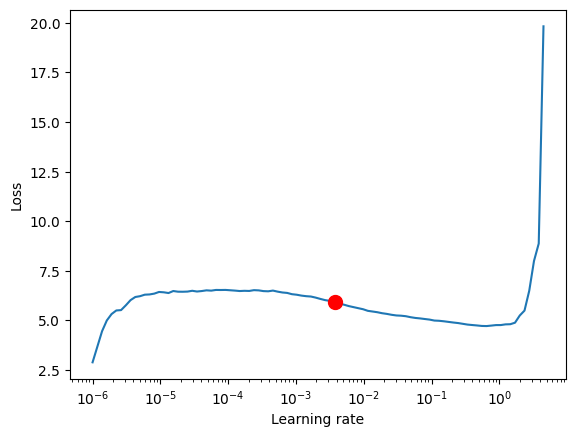

In [179]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### Train model

In [163]:
from lightning.pytorch import Callback

# callback to log loss while training/validation for each epoch
class LossCallback(Callback):
    def __init__(self):
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.epoch_losses.append(trainer.logged_metrics['train_loss_step'])
        self.epoch_val_losses.append(trainer.logged_metrics['val_loss'])

In [194]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.1, patience=3, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

loss_callback = LossCallback()

trainer = pl.Trainer(
    max_epochs=30,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=6,
    limit_train_batches=32,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback, loss_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.003,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.4,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Adam",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 73.9k


In [195]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 414   
3  | prescalers                         | ModuleDict                      | 272   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 16.2 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.3 

Epoch 8: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s, v_num=11, train_loss_step=1.900, val_loss=2.180, train_loss_epoch=2.000]


## Plot Loss Curve

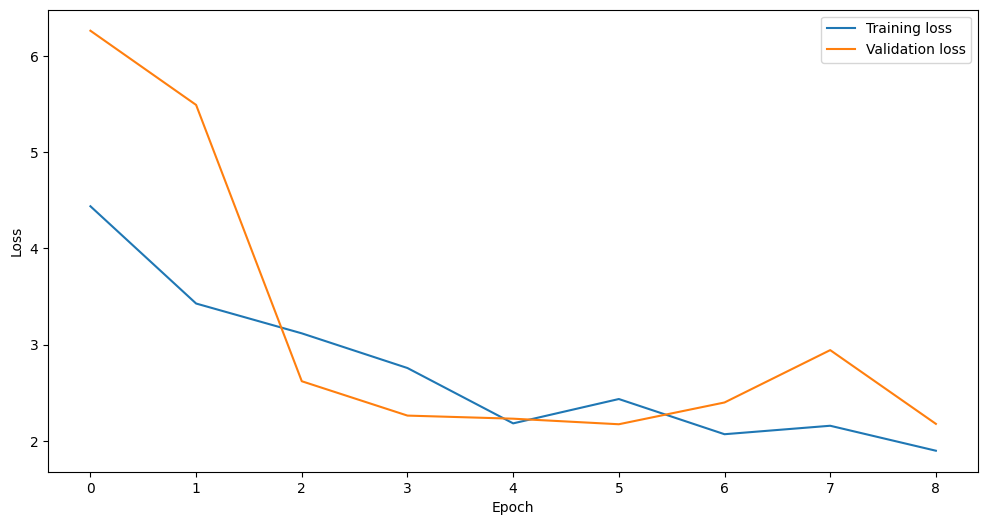

In [196]:
import matplotlib.pyplot as plt
# Plot the loss curve
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(loss_callback.epoch_losses, label='Training loss')
ax.plot(loss_callback.epoch_val_losses, label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [197]:
'''
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)
'''

'\nimport pickle\n\nfrom pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters\n\n# create study\nstudy = optimize_hyperparameters(\n    train_dataloader,\n    val_dataloader,\n    model_path="optuna_test",\n    n_trials=200,\n    max_epochs=50,\n    gradient_clip_val_range=(0.01, 1.0),\n    hidden_size_range=(8, 128),\n    hidden_continuous_size_range=(8, 128),\n    attention_head_size_range=(1, 4),\n    learning_rate_range=(0.001, 0.1),\n    dropout_range=(0.1, 0.3),\n    trainer_kwargs=dict(limit_train_batches=30),\n    reduce_on_plateau_patience=4,\n    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder\n)\n\n# save study results - also we can resume tuning at a later point in time\nwith open("test_study.pkl", "wb") as fout:\n    pickle.dump(study, fout)\n\n# show best hyperparameters\nprint(study.best_trial.params)\n'

In [198]:
trainer.test(best_tft, val_dataloader)

Testing DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_MAE          │    10.591941833496094     │
│         test_MAPE         │    0.11235976964235306    │
│         test_RMSE         │    10.916098594665527     │
│        test_SMAPE         │    0.10599923878908157    │
│         test_loss         │     5.086741924285889     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.086741924285889,
  'test_SMAPE': 0.10599923878908157,
  'test_MAE': 10.591941833496094,
  'test_RMSE': 10.916098594665527,
  'test_MAPE': 0.11235976964235306}]

In [199]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [200]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(2.3196)

## Plot Validation Prediction

In [201]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

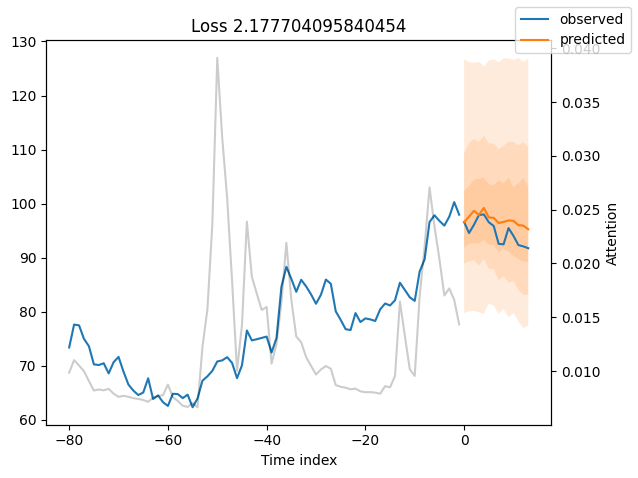

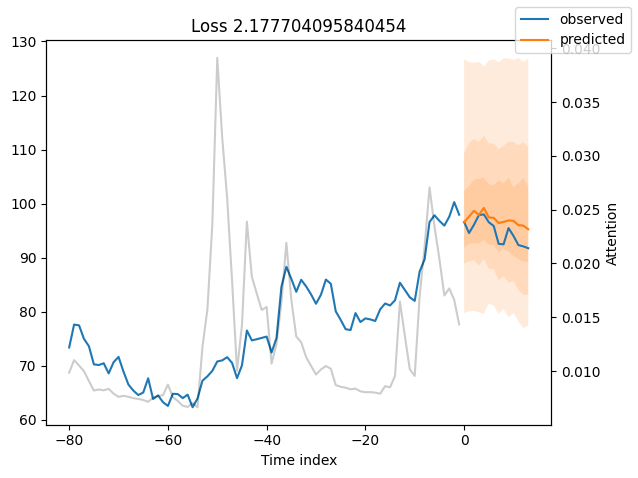

In [202]:
best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Close_center': <Figure size 1000x500 with 2 Axes>,
 'Close_scale': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'SMA_50': <Figure size 1000x500 with 2 Axes>,
 'SMA_200': <Figure size 1000x500 with 2 Axes>,
 'BBL_20_2_0': <Figure size 1000x500 with 2 Axes>,
 'BBM_20_2_0': <Figure size 1000x500 with 2 Axes>,
 'BBU_20_2_0': <Figure size 1000x500 with 2 Axes>,
 'BBB_20_2_0': <Figure size 1000x500 with 2 Axes>,
 'BBP_20_2_0': <Figure size 1000x500 with 2 Axes>,
 'RSI_14': <Figure size 1000x500 with 2 Axes>,
 'MACD_8_21_9': <Figure size 1000x500 with 2 Axes>,
 'MACDh_8_21_9': <Figure size 1000x500 with 2 Axes>,
 'MACDs_8_21_9': <Figure size 1000x500 with 2 Axes>,
 'VOLUME_SMA_20': <Figure size 1000x500 with 2 Axes>,
 'Volume': <Figure size 1000x500 with 2 Axes>,
 'static': <Figure size 640x480 with 2 Axes>,
 'month': <Figure size 1000x500 with 2 Axes>,
 'day': <Figure size 1000x500 with

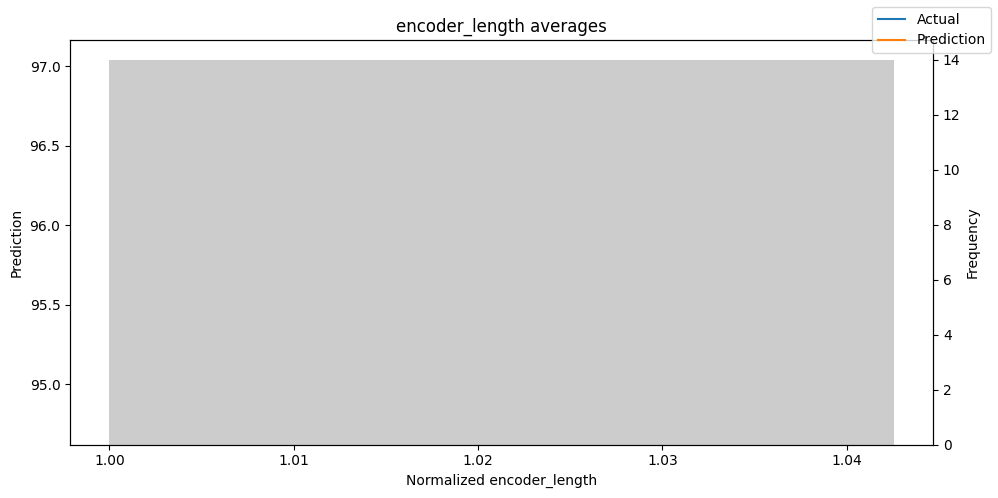

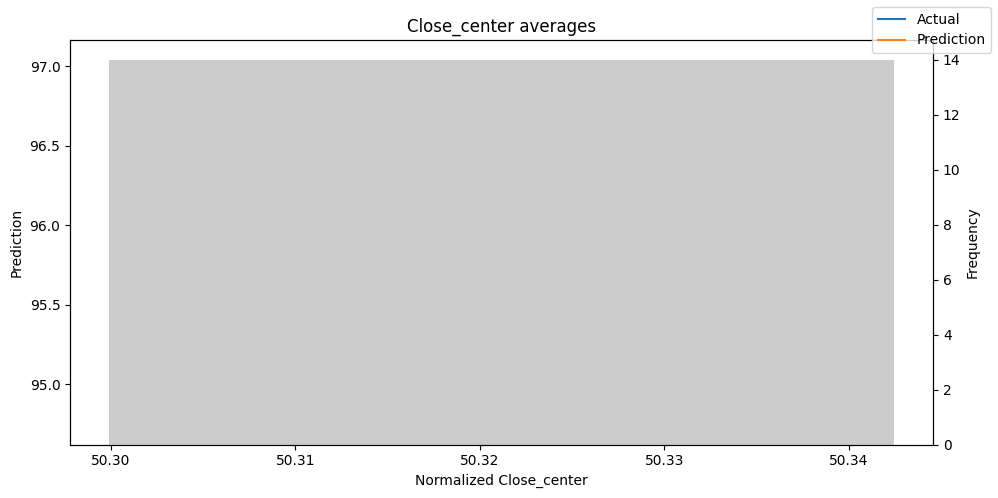

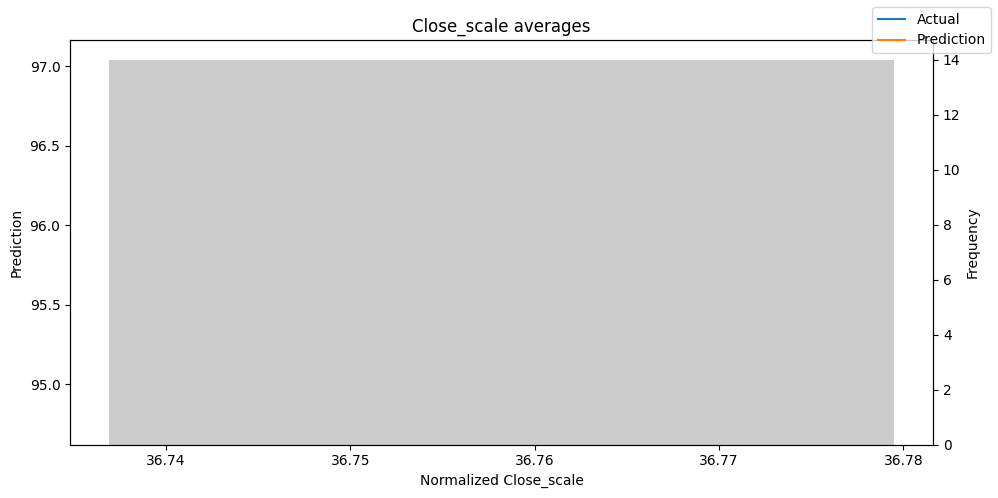

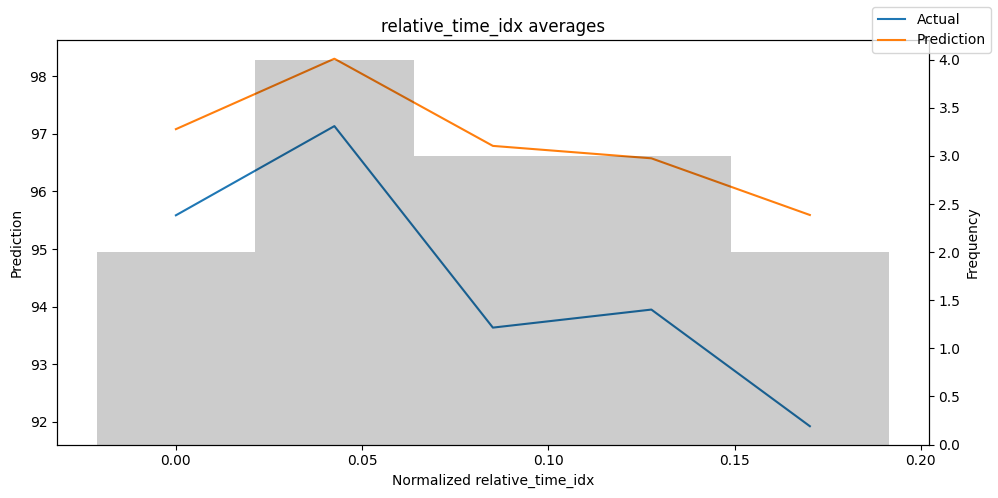

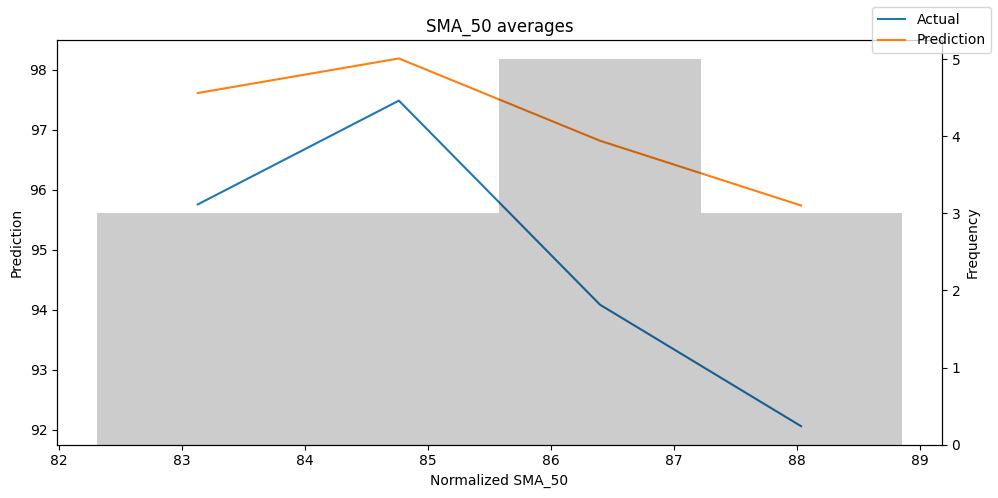

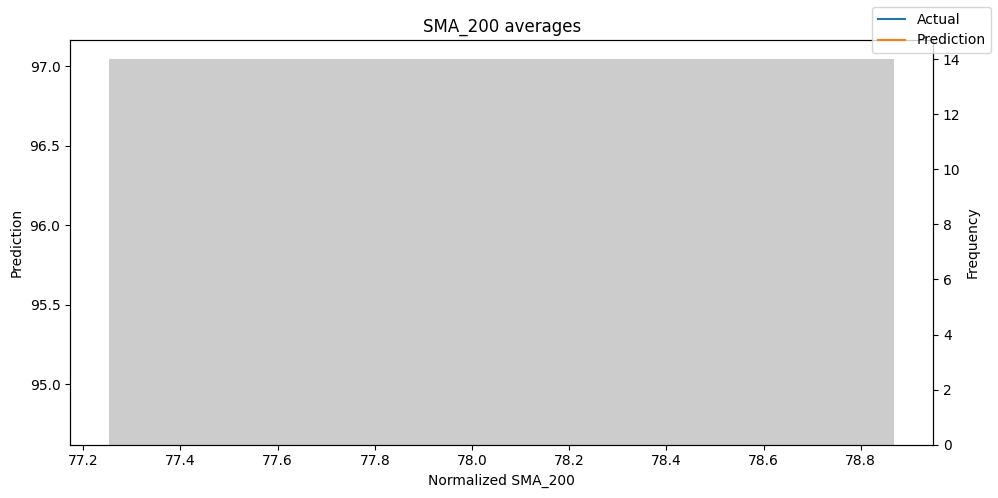

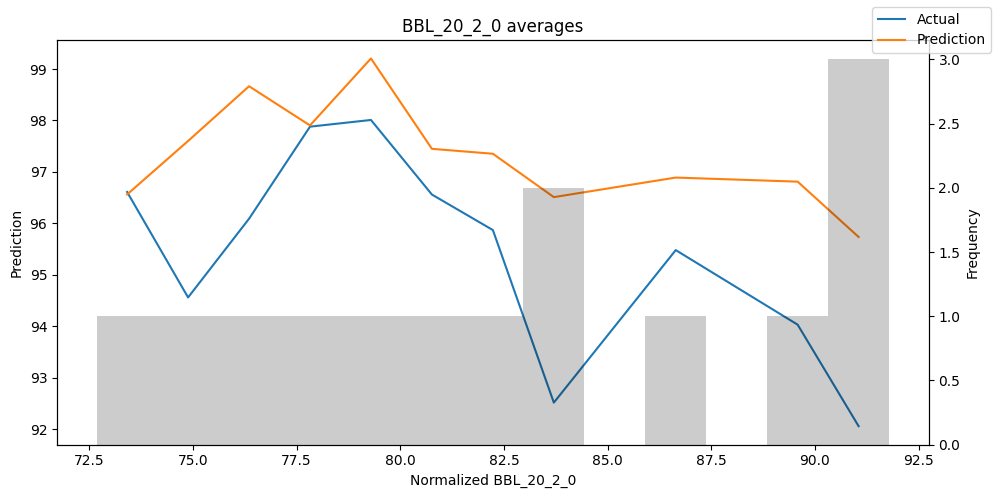

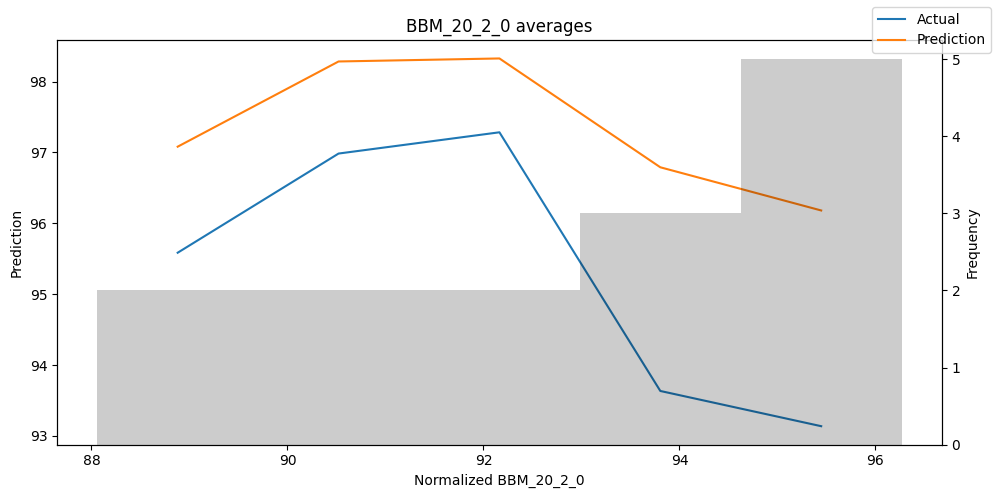

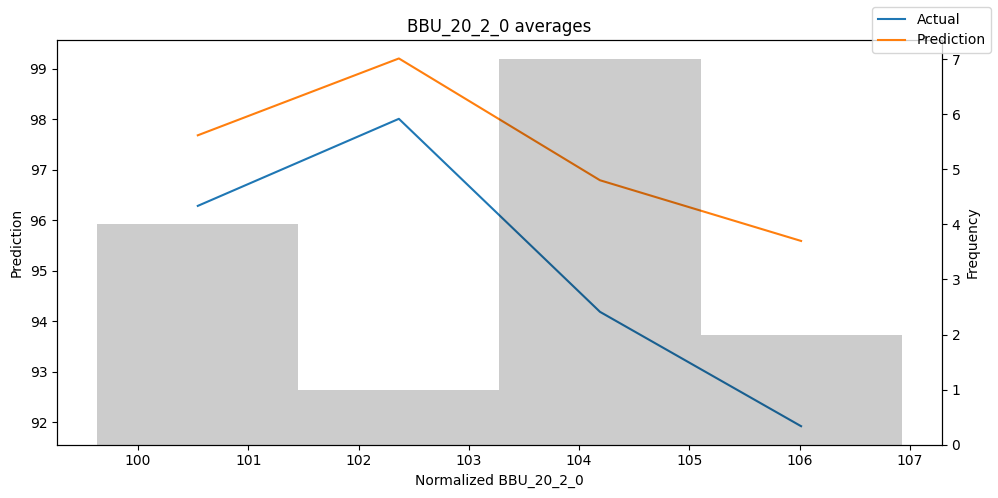

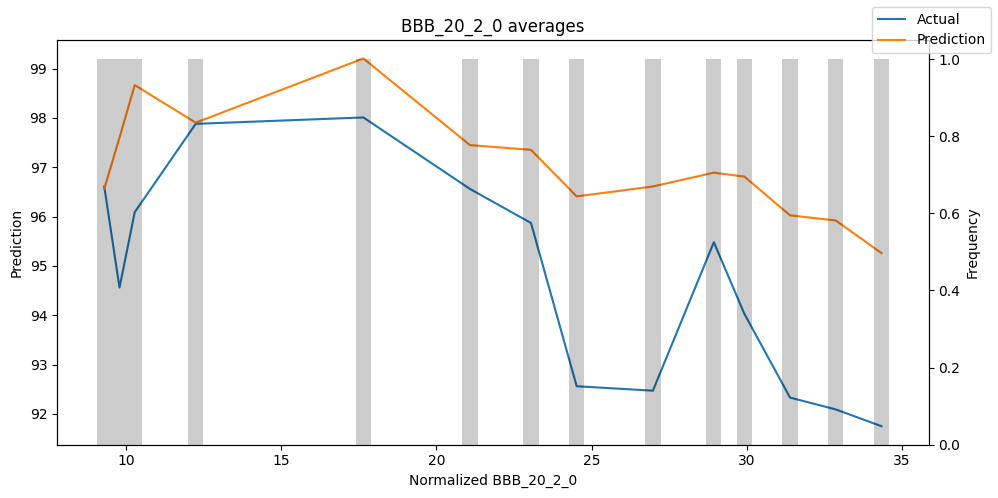

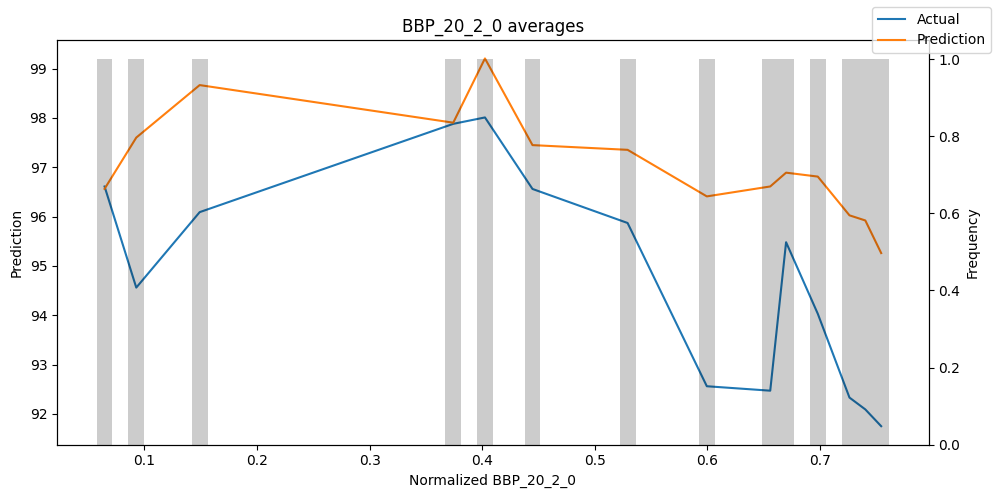

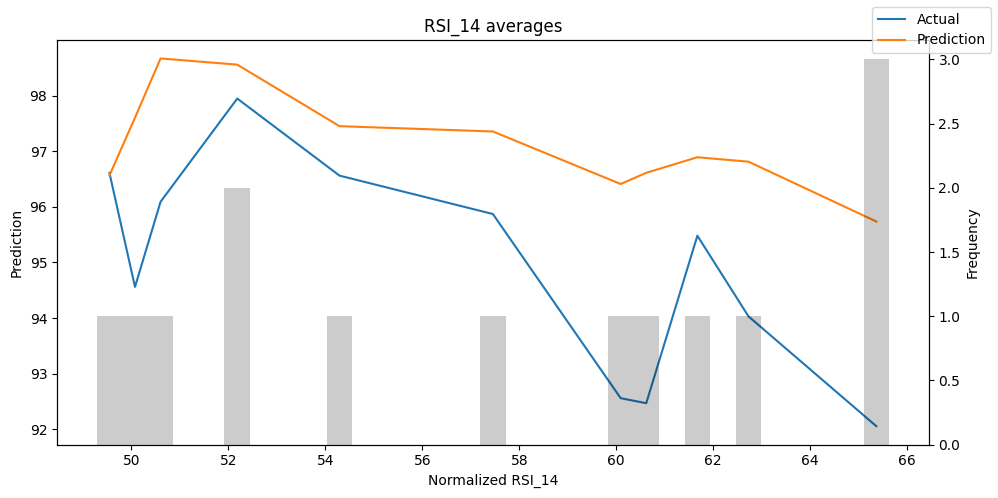

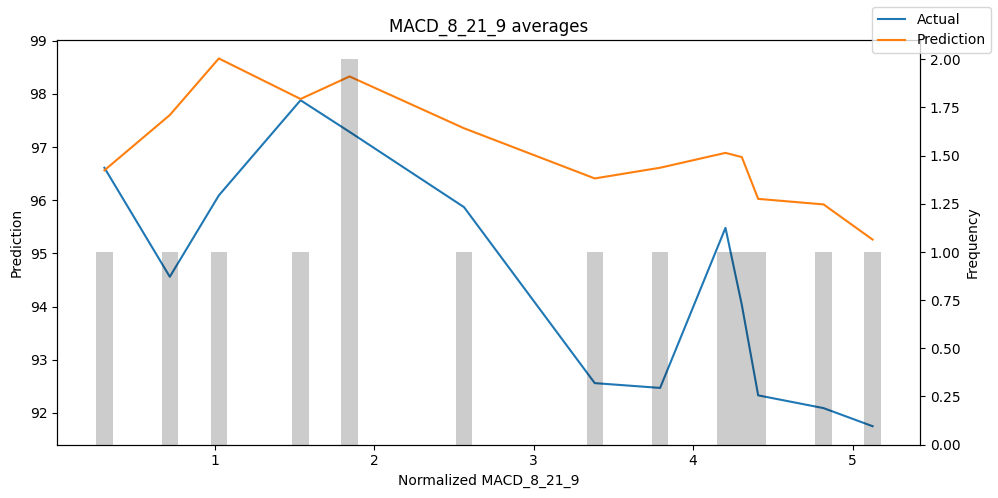

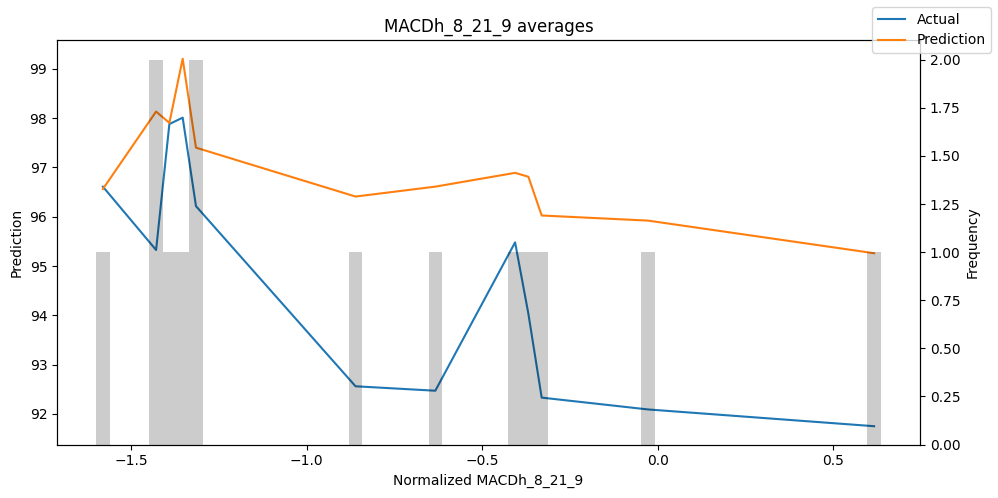

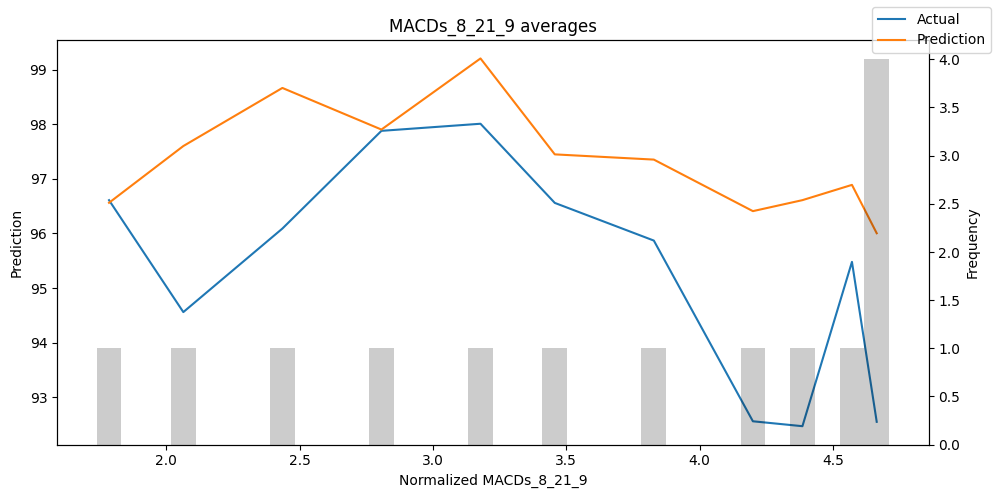

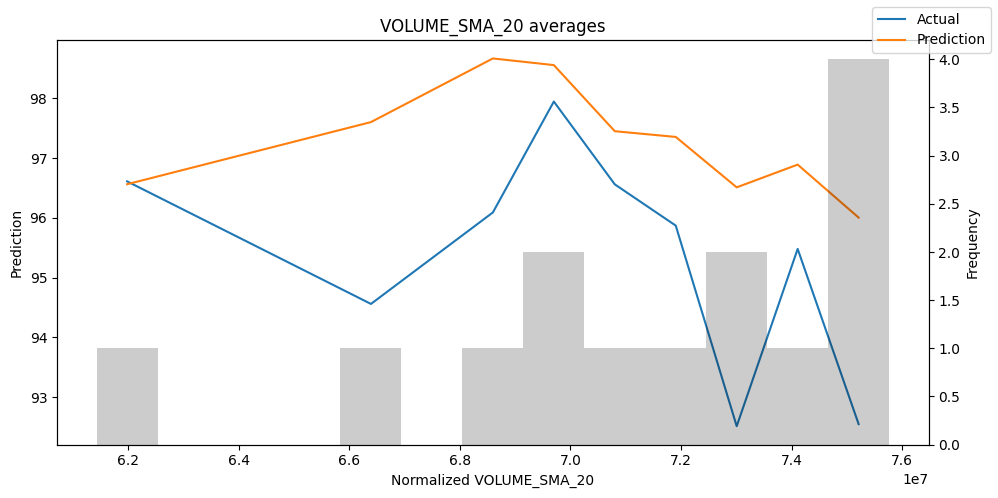

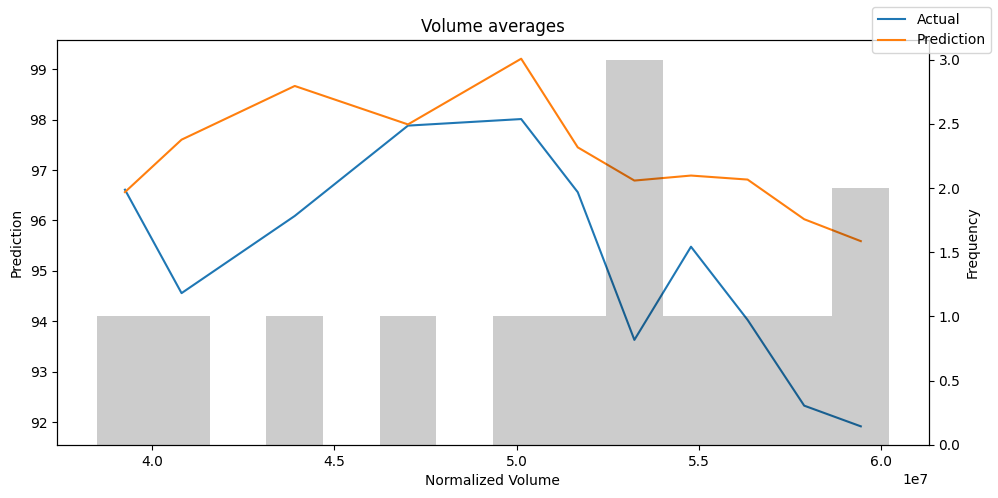

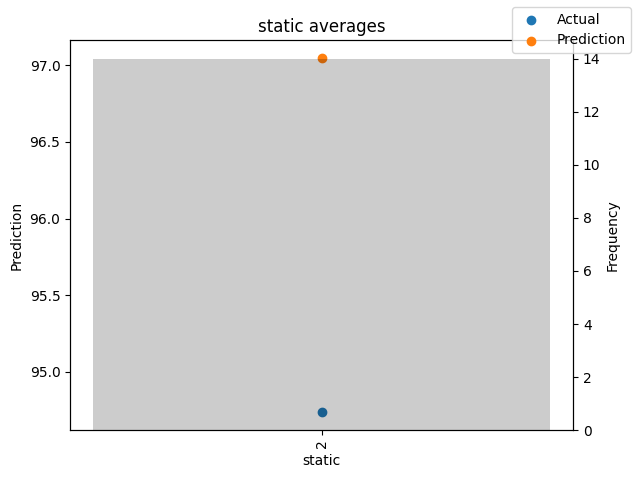

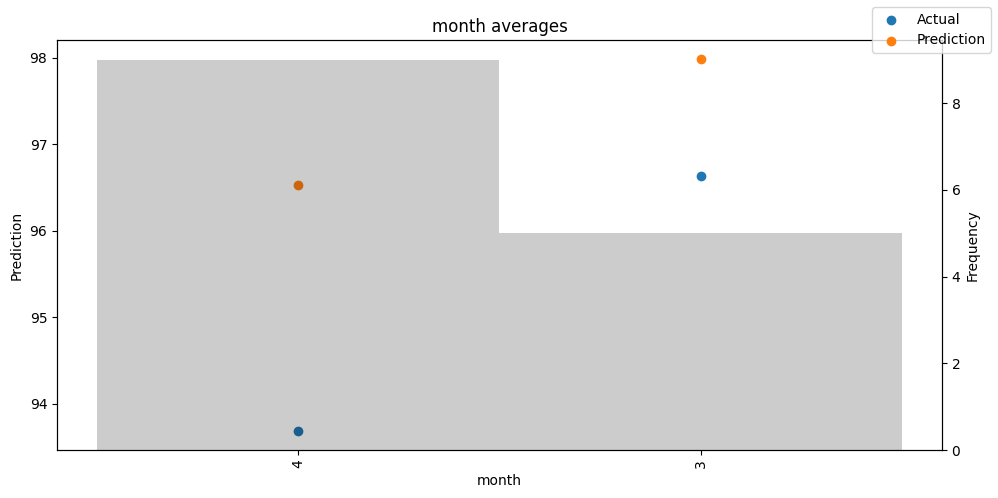

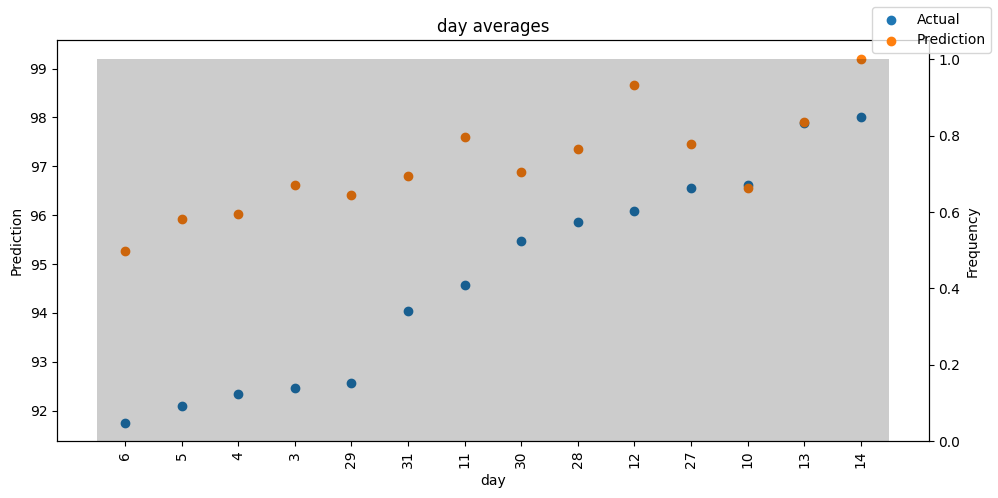

In [203]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x600 with 1 Axes>,
 'decoder_variables': <Figure size 700x275 with 1 Axes>}

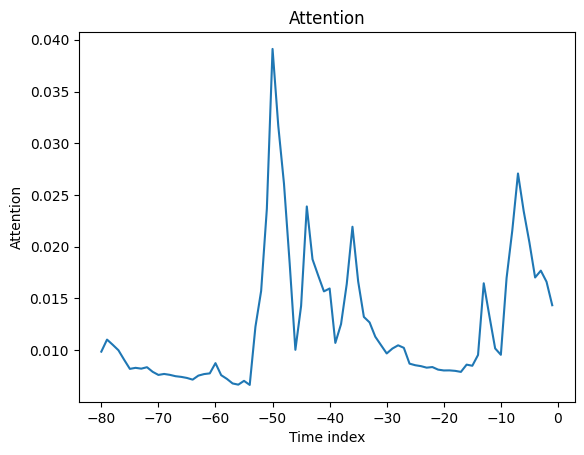

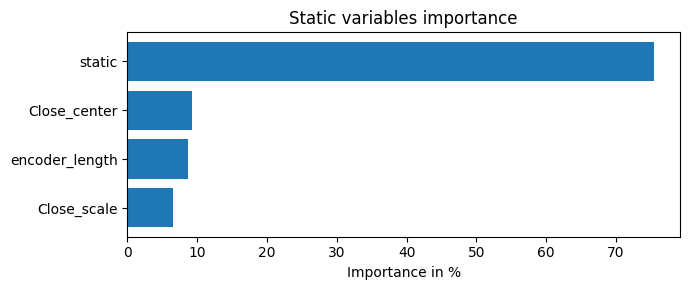

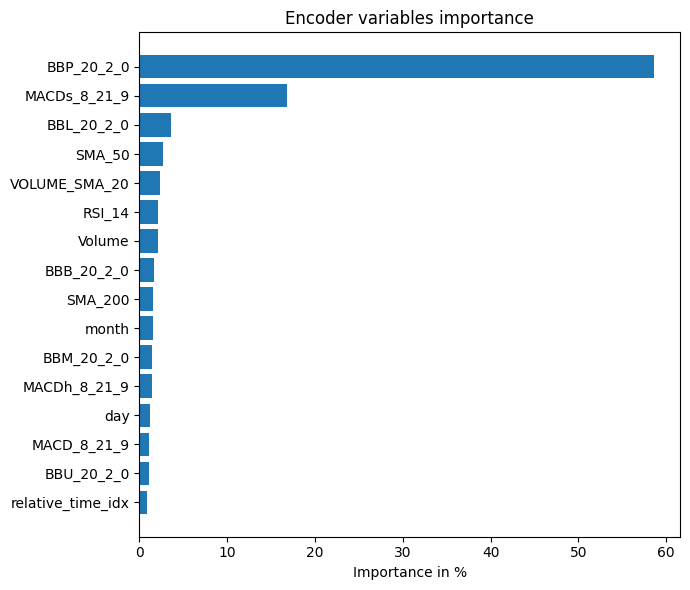

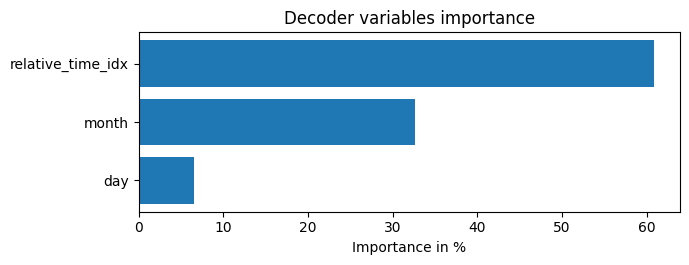

In [204]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [205]:
"""
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);
"""

'\nraw_prediction, x = best_tft.predict(\n    training.filter(lambda x: (x.time_idx_first_prediction == 15)),\n    mode="raw",\n    return_x=True,\n)\nbest_tft.plot_prediction(x, raw_prediction, idx=0);\n'

## Create new Prediction based on latest Data

In [206]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.BusinessDay(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data.index
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

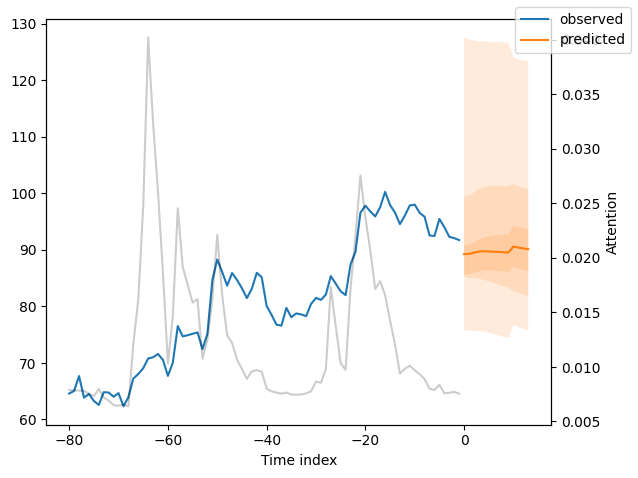

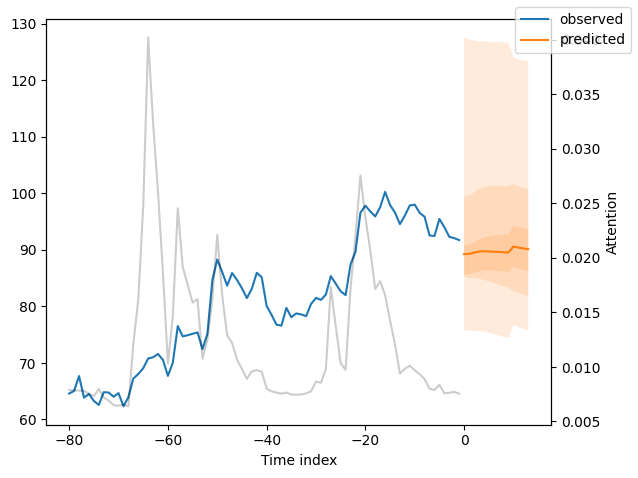

In [207]:
new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=False)